## Imports

In [1]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# hyperparameter optimisation
import kerastuner as kt
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist

/var/folders/7w/m_ccc09d3tx8dm80w7rxqz600000gn/T/ipykernel_54856/3683033310.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Get our waveform training set

In [2]:
# read in waveform dataframe

waveforms = pd.read_parquet('all_msci_waveforms_df.parquet')
print('Waveforms Set')
waveforms.info()
waveforms.head()

Waveforms Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18139 entries, 0 to 18138
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   runID    18139 non-null  uint64
 1   eventID  18139 non-null  uint64
 2   times    18139 non-null  object
 3   samples  18139 non-null  object
 4   length   18139 non-null  int64 
dtypes: int64(1), object(2), uint64(2)
memory usage: 708.7+ KB


,runID,eventID,times,samples,length
0,6940,941,"[-1442.0, -1432.0, -1422.0, -1412.0, -1402.0, ...","[0.00371349323540926, 0.011231761425733566, 0....",450
1,6940,2797,"[-3062.0, -3052.0, -3042.0, -3032.0, -3022.0, ...","[-0.0005877960938960314, 0.0009018611162900925...",865
2,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101
3,6940,3705,"[-522.0, -512.0, -502.0, -492.0, -482.0, -472....","[0.0011612486559897661, 0.009089636616408825, ...",600
4,6940,6386,"[-2032.0, -2022.0, -2012.0, -2002.0, -1992.0, ...","[0.00023173866793513298, 0.0002317386679351329...",466


In [3]:
# read in tritium and background datasets and combine

trit_data = pd.read_csv('../Decision Tree Analysis/data/tritium_ML_data.csv')
bkg_data = pd.read_csv('../Decision Tree Analysis/data/bg_sr1_vetoes_gassplit.csv')
orig_train = pd.concat([trit_data, bkg_data], ignore_index=True)
orig_train = orig_train.drop('Unnamed: 0', axis = 1)
print('Original Dataset')
orig_train.info()
orig_train.head()

Original Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23517 entries, 0 to 23516
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             23517 non-null  int64  
 1   eventID           23517 non-null  int64  
 2   area              23517 non-null  float64
 3   max_pulse_height  23517 non-null  float64
 4   ext_elec          23517 non-null  float64
 5   x                 23517 non-null  float64
 6   y                 23517 non-null  float64
 7   r                 23517 non-null  float64
 8   S2_width          23517 non-null  float64
 9   label             23517 non-null  int64  
 10  type              23517 non-null  object 
 11  dt10_05           23517 non-null  float64
 12  dt25_10           23517 non-null  float64
 13  dt50_25           23517 non-null  float64
 14  dt75_50           23517 non-null  float64
 15  dt90_75           23517 non-null  float64
 16  dt95_90           23517

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


- Binary Classification: 
    - Background - 0
    - Signal - 1
- Multi-class Classification:
    - Cathode - 0
    - Gate - 1
    - Tritium - 2

In [4]:
# Remove gas events from our waveform set
# Then set background events to a label=0 and signal calibration events to a label=1

final_dataset = data.waveforms_of_truth(waveforms, orig_train)
df_gas_cut = final_dataset[final_dataset["type"] != 'gas']
# df_gas_cut.loc[df_gas_cut["type"] == "tritium", "label"] = 1
# df_gas_cut.loc[df_gas_cut["type"] == "gate", "label"] = 0
df_gas_cut.info()
df_gas_cut.head()

Rows with length = 0 have been removed from the waveform data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9686 entries, 2 to 17602
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             9686 non-null   uint64 
 1   eventID           9686 non-null   uint64 
 2   times             9686 non-null   object 
 3   samples           9686 non-null   object 
 4   length            9686 non-null   int64  
 5   area              9686 non-null   float64
 6   max_pulse_height  9686 non-null   float64
 7   ext_elec          9686 non-null   float64
 8   x                 9686 non-null   float64
 9   y                 9686 non-null   float64
 10  r                 9686 non-null   float64
 11  S2_width          9686 non-null   float64
 12  label             9686 non-null   int64  
 13  type              9686 non-null   object 
dtypes: float64(7), int64(2), object(3), uint64(2)
memory usage: 1.1+ MB


,runID,eventID,times,samples,length,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type
2,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101,9605.476562,2.721810,204.067911,42.940289,28.632875,51.611142,11120.0,0,cathode
3,6940,3705,"[-522.0, -512.0, -502.0, -492.0, -482.0, -472....","[0.0011612486559897661, 0.009089636616408825, ...",600,1831.674072,2.608893,38.913832,23.994717,41.210274,47.686823,1920.0,1,gate
6,6940,7831,"[-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...","[0.0009631378925405443, 0.0009631378925405443,...",932,8454.574219,2.998639,179.617043,-10.792992,-21.832264,24.354392,8570.0,0,cathode
8,6940,9904,"[-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...","[-0.003676149994134903, -0.004674938507378101,...",525,10806.775391,7.274445,229.589450,45.577667,18.305967,49.116516,3760.0,1,gate
11,6940,15136,"[-823.0, -813.0, -803.0, -793.0, -783.0, -773....","[-0.004523166920989752, 0.0026921471580863, -0...",640,11460.135742,8.490430,243.470060,28.943817,44.150917,52.792500,2810.0,1,gate


## Get the weights of the dataset based on S2 size

In [5]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

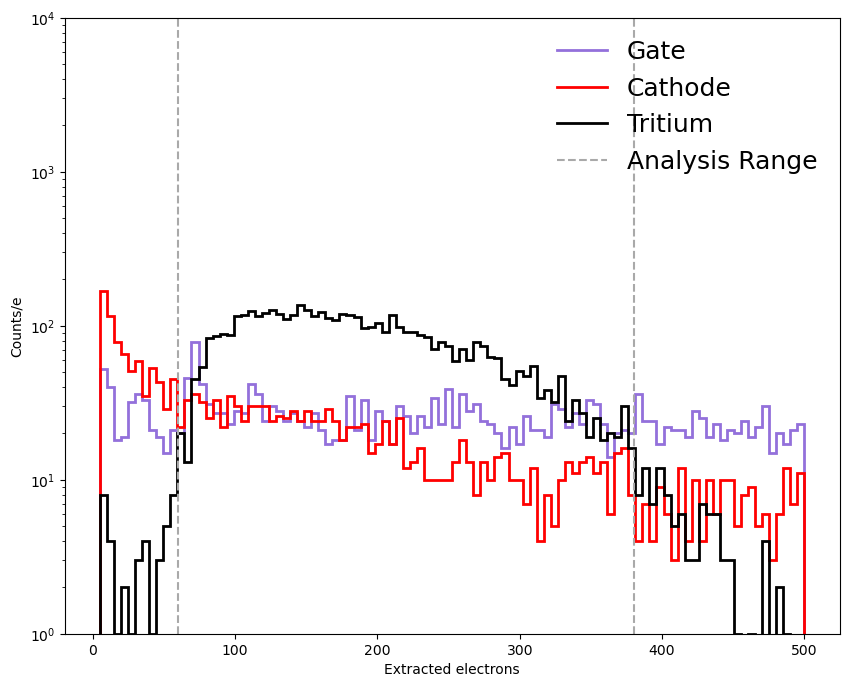

In [6]:
gate_hist = Hist(electron_axis)
gate_cut = df_gas_cut.type == "gate"
gate_hist.fill(df_gas_cut.ext_elec[gate_cut])

# gas_hist = Hist(electron_axis)
# gas_cut = padded_data.type == "gas"
# gas_hist.fill(padded_data.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df_gas_cut.type == "cathode"
cath_hist.fill(df_gas_cut.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df_gas_cut.type == "tritium"
trit_hist.fill(df_gas_cut.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
# gas_hist.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [7]:
# implementing thresholds
thresh_cut = (60 < df_gas_cut.ext_elec) & (df_gas_cut.ext_elec < 380)
df_gas_and_thresh_cut = df_gas_cut[thresh_cut].reset_index().drop('index', axis = 1)

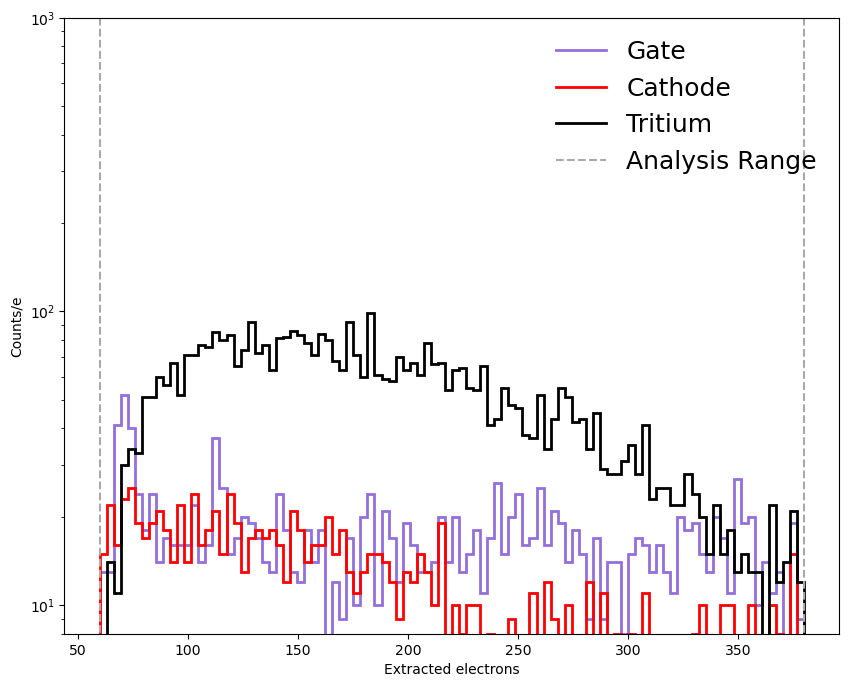

In [8]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_gas_and_thresh_cut.type == "gate"
gate_hist2.fill(df_gas_and_thresh_cut.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_gas_and_thresh_cut.type == "cathode"
cath_hist2.fill(df_gas_and_thresh_cut.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_gas_and_thresh_cut.type == "tritium"
trit_hist2.fill(df_gas_and_thresh_cut.ext_elec[trit_cut2])

# gas_hist2 = Hist(electron_axis2)
# gas_cut2 = padded_data.type == "gas"
# gas_hist2.fill(padded_data.ext_elec[gas_cut2])


fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
# gas_hist2.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,1000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [9]:
#weighting data w/o gas events 
weight_list = []

for ii in range(df_gas_and_thresh_cut.shape[0]):
    if df_gas_and_thresh_cut.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_gas_and_thresh_cut.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_gas_and_thresh_cut.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_gas_and_thresh_cut['weights_no_gas'] = weight_list
print(df_gas_and_thresh_cut['weights_no_gas'].to_numpy().shape)

(7782,)


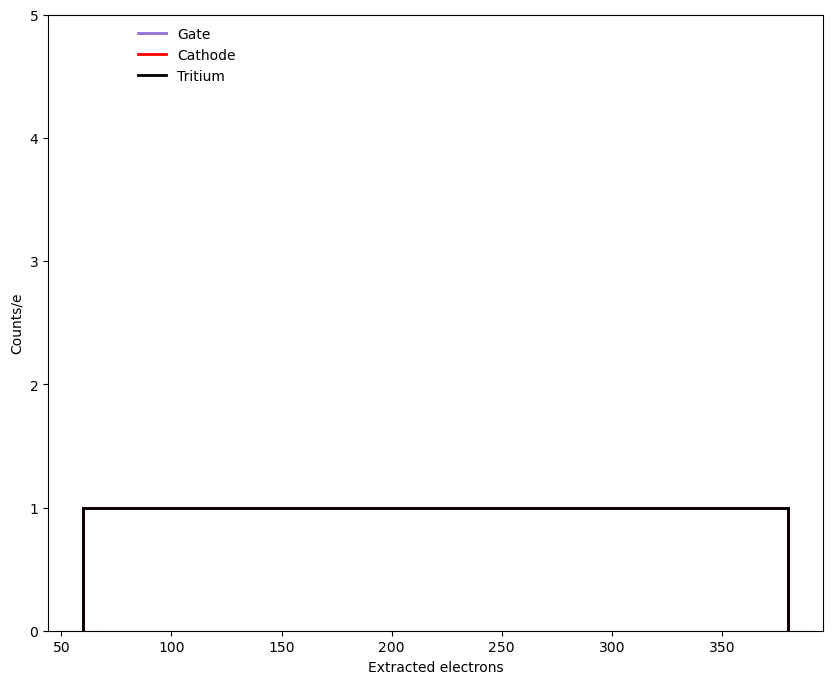

In [10]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_gas_and_thresh_cut.ext_elec[gate_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_gas_and_thresh_cut.ext_elec[cath_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_gas_and_thresh_cut.ext_elec[trit_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

## Final ML Datasets

In [11]:
# prepare data for machine learning
# pad on data set after threshold cut and 

padded_data = data.pad_waveforms(df_gas_and_thresh_cut)
print('Waveform Dataset')
padded_data.info()
print('\nMax Waveform Length - ' + str(padded_data.length.max()))

Waveform Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7782 entries, 0 to 7781
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             7782 non-null   uint64 
 1   eventID           7782 non-null   uint64 
 2   times             7782 non-null   object 
 3   samples           7782 non-null   object 
 4   length            7782 non-null   int64  
 5   area              7782 non-null   float64
 6   max_pulse_height  7782 non-null   float64
 7   ext_elec          7782 non-null   float64
 8   x                 7782 non-null   float64
 9   y                 7782 non-null   float64
 10  r                 7782 non-null   float64
 11  S2_width          7782 non-null   float64
 12  label             7782 non-null   int64  
 13  type              7782 non-null   object 
 14  weights_no_gas    7782 non-null   float64
 15  padded_samples    7782 non-null   object 
dtypes: float64(8), int64(2), 

In [12]:
# finalising the data arrays

padded_array = padded_data['padded_samples'].to_numpy()
x_data = np.stack(padded_array, axis=0)
# divide by max phd
max_phd = x_data.max()
x_data = x_data / max_phd
# set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
x_data[x_data < 0] = 0
# waveform intensity range should now be between zero and 1.
print(x_data.min())
print(x_data.max())
print(x_data.shape)

y_data = padded_data['label'].to_numpy().reshape((-1,1))
print(y_data.shape)

input_length = x_data.shape[-1]
print(input_length)

0.0
1.0
(7782, 1828)
(7782, 1)
1828


In [13]:
# get training and testing sets
runID = padded_data['runID']
eventID = padded_data['eventID']
W_array = padded_data['weights_no_gas'].to_numpy().reshape((-1,1))

X_train, X_test, \
y_train, y_test, \
W_train, W_test, \
runID_train, runID_test, \
eventID_train, eventID_test = \
train_test_split(x_data, y_data, W_array, runID, eventID, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(W_train.shape)


(5836, 1828)
(5836, 1)
(5836, 1)


In [14]:
# writing the data function

def data_func():
    waveforms = pd.read_parquet('all_msci_waveforms_df.parquet')
    
    trit_data = pd.read_csv('../Decision Tree Analysis/data/tritium_ML_data.csv')
    bkg_data = pd.read_csv('../Decision Tree Analysis/data/bg_sr1_vetoes_gassplit.csv')
    orig_train = pd.concat([trit_data, bkg_data], ignore_index=True)
    orig_train = orig_train.drop('Unnamed: 0', axis = 1)

    final_dataset = data.waveforms_of_truth(waveforms, orig_train)
    df_gas_cut = final_dataset[final_dataset["type"] != 'gas']

    electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                                      label="Extracted electrons",flow=False)
    
    # implementing thresholds
    thresh_cut = (60 < df_gas_cut.ext_elec) & (df_gas_cut.ext_elec < 380)
    df_gas_and_thresh_cut = df_gas_cut[thresh_cut].reset_index().drop('index', axis = 1)
    
    # histogram with threshold data
    electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                            label="Extracted electrons",flow=False)

    gate_hist2 = Hist(electron_axis2)
    gate_cut2 = df_gas_and_thresh_cut.type == "gate"
    gate_hist2.fill(df_gas_and_thresh_cut.ext_elec[gate_cut2])

    cath_hist2 = Hist(electron_axis2)
    cath_cut2 = df_gas_and_thresh_cut.type == "cathode"
    cath_hist2.fill(df_gas_and_thresh_cut.ext_elec[cath_cut2])

    trit_hist2 = Hist(electron_axis2)
    trit_cut2 = df_gas_and_thresh_cut.type == "tritium"
    trit_hist2.fill(df_gas_and_thresh_cut.ext_elec[trit_cut2])

    #weighting data w/o gas events 
    weight_list = []

    for ii in range(df_gas_and_thresh_cut.shape[0]):
        if df_gas_and_thresh_cut.type[ii] == 'gate':
            index = np.searchsorted(gate_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
            bin_counts = gate_hist2[index]
        elif df_gas_and_thresh_cut.type[ii] == 'cathode':
            index = np.searchsorted(cath_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
            bin_counts = cath_hist2[index]
        elif df_gas_and_thresh_cut.type[ii] == 'tritium':
            index = np.searchsorted(trit_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
            bin_counts = trit_hist2[index]     
        weight_list.append(1/bin_counts)
        
    df_gas_and_thresh_cut['weights_no_gas'] = weight_list

    padded_data = data.pad_waveforms(df_gas_and_thresh_cut)

    # finalising the data arrays
    padded_array = padded_data['padded_samples'].to_numpy()
    x_data = np.stack(padded_array, axis=0)
    # divide by max phd
    max_phd = x_data.max()
    x_data = x_data / max_phd
    # set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
    x_data[x_data < 0] = 0
    # waveform intensity range should now be between zero and 1.

    y_data = padded_data['label'].to_numpy().reshape((-1,1))

    input_length = x_data.shape[-1]

    # get training and testing sets
    runID = padded_data['runID']
    eventID = padded_data['eventID']
    W_array = padded_data['weights_no_gas'].to_numpy()

    X_train, X_test, \
    y_train, y_test, \
    W_train, W_test, \
    runID_train, runID_test, \
    eventID_train, eventID_test = \
    train_test_split(x_data, y_data, W_array, runID, eventID, random_state=0)
    return X_train, y_train, W_train, X_test, y_test, W_test

In [15]:
# writing the model function

def model_builder(hp):
    model = keras.Sequential()

    model.add(Masking(mask_value=0., input_shape=(input_length, 1)))

    model.add(Conv1D(filters=32,kernel_size=3,activation='relu', padding='valid'))
    model.add(MaxPooling1D(2))
    # tuning of a dropout layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=1.0, sampling='linear')))

    model.add(Conv1D(filters=64,kernel_size=5,activation='relu', padding='valid'))
    model.add(MaxPooling1D(2))
    # tuning of a dropout layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=1.0, sampling='linear')))

    model.add(Conv1D(filters=128,kernel_size=9,activation='relu', padding='valid'))
    # model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    # tuning of a dropout layer
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=1.0, sampling='linear')))

    model.add(Flatten())
    model.add(Dense(60, activation='leaky_relu'))
    # model.add(BatchNormalization())
    # tuning of a dropout layer
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=1.0, sampling='linear')))

    model.add(Dense(10, activation='leaky_relu'))
    # model.add(BatchNormalization())
    # tuning of a dropout layer
    model.add(Dropout(rate=hp.Float('dropout_5', min_value=0.0, max_value=1.0, sampling='linear')))

    model.add(Dense(3, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'])
    
    return model

In [16]:
tuner = kt.Hyperband(model_builder,
                     objective='val_weighted_accuracy',
                     max_epochs=10,
                     factor=3,)
                     #directory='my_dir',
                     #project_name='intro_to_kt')

2024-03-18 18:08:12.115260: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-18 18:08:12.115507: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-18 18:08:12.115523: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-18 18:08:12.115932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 18:08:12.116456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Optimising Hypers

In [17]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

Trial 30 Complete [00h 00m 47s]
val_weighted_accuracy: 0.863869845867157

Best val_weighted_accuracy So Far: 0.880993127822876
Total elapsed time: 00h 10m 01s


In [18]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_weighted_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
dropout_1: 0.566785156552437
dropout_2: 0.2868092826196117
dropout_3: 0.2021076924868369
dropout_4: 0.06564186957376483
dropout_5: 0.007888861036023043
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.880993127822876

Trial 0021 summary
Hyperparameters:
dropout_1: 0.566785156552437
dropout_2: 0.2868092826196117
dropout_3: 0.2021076924868369
dropout_4: 0.06564186957376483
dropout_5: 0.007888861036023043
learning_rate: 0.0001
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8732876777648926

Trial 0016 summary
Hyperparameters:
dropout_1: 0.0546154398638623
dropout_2: 0.45299320092368955
dropout_3: 0.8494834077958657
dropout_4: 0.49825827386527144
dropout_5: 0.3265293309349162
learning_rate: 0.001
tuner/epochs: 10
tuner/init

## Evaluating the model

In [19]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

61/61 [==============================] - 1s 15ms/step - loss: 0.3526 - accuracy: 0.8684 - weighted_accuracy: 0.8684


[0.3525902032852173, 0.8684480786323547, 0.8684480786323547]

In [20]:
y_predicted = best_model.predict(X_test)
y_predicted_label = [np.argmax(i) for i in y_predicted]

61/61 [==============================] - 1s 10ms/step


Text(95.72222222222221, 0.5, 'Truth')

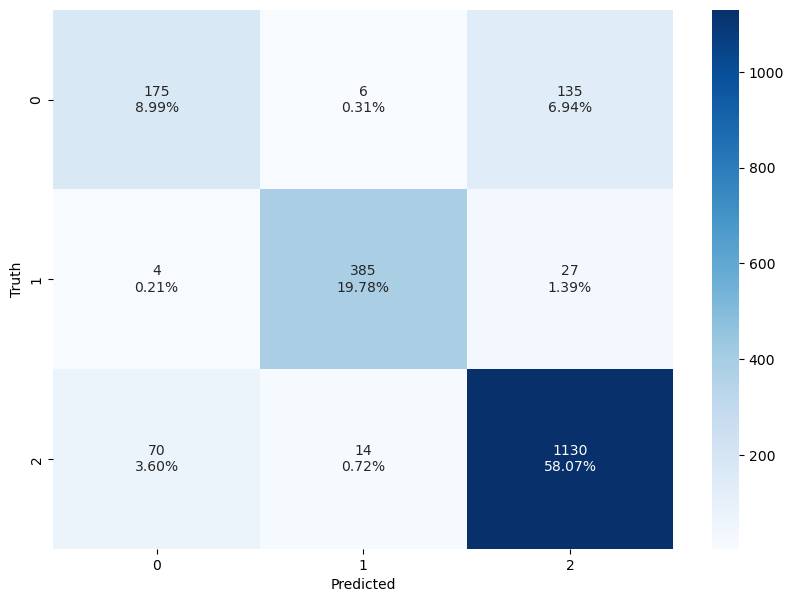

In [21]:
plt.figure(figsize = (10,7))
cf_matrix = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label).numpy()

# group_names = ['True Cathode','False Gate', 'False Signal', 
#                'False Cathode','True Gate', 'False Signal',
#                'False']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
          #zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')